# Getting Data from MTA Yellow Taxi

In [111]:
import pandas as pd
import requests
import re
from tqdm import tqdm
import time
import os
import glob
import math
from keplergl import KeplerGl

In [285]:

from bs4 import BeautifulSoup
  
URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
r = requests.get(URL)
  
soup = BeautifulSoup(r.content, 'html5lib') 
# print(soup.prettify())

In [8]:
soup = BeautifulSoup(r.content)
table = soup.find_all('a',title="Yellow Taxi Trip Records")

In [286]:
# table

In [5]:
type(table)

bs4.element.ResultSet

In [6]:

links=[]
for row in table:
    match = re.search(r'href=[\'"]?([^\'" >]+)', str(row))
    if match:
        links.append(str(match.group(1)))

In [287]:
# links

In [8]:
pattern = r"(?P<prefix>.*)(?P<tripdata>tripdata_)(?P<year>[0-9]{4})-(?P<month>[0-9]{2})(?P<rest>.*)"
newlinks=[]
for eachlink in links:
    match=re.search(pattern,eachlink)
    year=int(match.group("year"))
    month=int(match.group("month"))
    
    if (year>=2009) and (year<2015):
        newlinks.append(eachlink)
    elif (year==2015) and (month<=6):
        newlinks.append(eachlink)

In [9]:
newlinks

['https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-02.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-03.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-04.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-06.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-01.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-02.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-03.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-04.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-05.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-06.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-07.csv',
 'https://s3.amazonaws.co

In [10]:
def download_file(url):
    if not(os.path.exists("data")):
        os.mkdir("data")
    local_filename = url.split('/')[-1]
    local_filename="C:\\Users\\Kunal\\Desktop\\TFA\\data\\"+local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

In [59]:
# #DO NOT RUN-----------------------------------------------------------
# for i in tqdm(range(len(newlinks))):
#     eachlink=newlinks[i]
#     download_file(eachlink)
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [1:31:52<00:00, 70.67s/it]


In [11]:
path = "C:\\Users\\Kunal\\Desktop\\TFA\\data"
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [25]:
subset=pd.read_csv("C:\\Users\\Kunal\\Desktop\\TFA\\start.csv",on_bad_lines='skip')
df=pd.DataFrame()
mapping = {subset.columns[0]: 'vendor_name', 
           subset.columns[1]: 'Trip_Pickup_DateTime', 
           subset.columns[2]: 'Trip_Dropoff_DateTime', 
           subset.columns[3]: 'Passenger_Count',
           subset.columns[4]:'Trip_Distance', 
           subset.columns[5]:'Start_Lon', 
           subset.columns[6]:'Start_Lat',
           subset.columns[7]:'Rate_Code',
           subset.columns[8]:'store_and_forward',
           subset.columns[9]:'End_Lon',
           subset.columns[10]:'End_Lat',
           subset.columns[11]:'Payment_Type',
           subset.columns[12]:'Fare_Amt',
           subset.columns[13]:'surcharge',
           subset.columns[14]:'mta_tax',
           subset.columns[15]:'Tip_Amt',
           subset.columns[16]:'Tolls_Amt',
           subset.columns[17]:'Total_Amt'}

In [29]:
masterdf=pd.DataFrame()
for i in tqdm(range(len(csv_files))):
#     print(csv_files[i])
#     if(i<11):
#         continue
    df = df[0:0]   
    df = pd.read_csv(csv_files[i],on_bad_lines='skip')
    subset=df.sample(n=3000)
    if len(subset.columns)>18:
        subset=subset.drop(columns=["improvement_surcharge"],errors='ignore')
#         print("here")
    tempdf=subset
    tempdf.columns=mapping
    masterdf=masterdf.append(tempdf,ignore_index=True)
    subset.to_csv(r"C:\Users\Kunal\Desktop\TFA\sample\subset" +str(i)+ ".csv",index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [41:19<00:00, 31.79s/it]


In [30]:
len(masterdf)

234000

In [31]:
masterdf.to_csv("masterdf.csv",index=False)

In [22]:
masterdf.columns=['name', 'vendor_name', 'Trip_Pickup_DateTime',
       'Trip_Dropoff_DateTime', 'Passenger_Count', 'Trip_Distance',
       'Start_Lon', 'Start_Lat', 'Rate_Code', 'store_and_forward', 'End_Lon',
       'End_Lat', 'Payment_Type', 'Fare_Amt', 'surcharge', 'mta_tax',
       'Tip_Amt', 'Tolls_Amt']

In [23]:
masterdf.columns

Index(['name', 'vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt'],
      dtype='object')

# Distance function

* Calculate distance between pickup and drop location using math module

In [9]:
def distance(series):
    lat1, lon1 = float(series["Start_Lat"]),float(series["Start_Lon"])
    lat2, lon2 = float(series["End_Lat"]),float(series["End_Lon"])
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

# Outside Area Trip Removal Function 

* Remove trips that start and/or end outside of the latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.717047). 

In [10]:
def outside(dataframe):
    dataframe = dataframe[ (dataframe['Start_Lat'] >= 40.560445) & (dataframe['Start_Lat'] <= 40.908524)]
    dataframe = dataframe[ (dataframe['End_Lat'] >= 40.560445) & (dataframe['End_Lat'] <= 40.908524)]
    dataframe = dataframe[ (dataframe['Start_Lon'] >= -74.242330) & (dataframe['Start_Lon'] <= -73.717047)]
    dataframe = dataframe[ (dataframe['End_Lon'] >= -74.242330) & (dataframe['End_Lon'] <= -73.717047)]
    return dataframe
    

# Data Cleaning

-  __Yellow Taxi Data__

In [11]:
yellowdf=pd.read_csv("masterdf.csv")

C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\2527313409.py:1: DtypeWarning: Columns (0,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  yellowdf=pd.read_csv("masterdf.csv")


In [12]:
yellowdf.head()

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
0,CMT,2009-01-13 07:54:28,2009-01-13 08:00:10,2,0.60,-73.961570,40.768545,NaN,NaN,-73.963642,40.774218,Cash,4.9,0.0,NaN,0.0,0.00,4.90
1,CMT,2009-01-22 09:02:19,2009-01-22 09:45:48,1,21.10,-73.914399,40.746171,NaN,NaN,-73.816812,40.703619,Cash,49.3,0.0,NaN,0.0,0.00,49.30
2,CMT,2009-01-23 23:52:45,2009-01-24 00:13:43,1,10.70,-73.874395,40.774010,NaN,NaN,-73.981739,40.765671,Cash,25.8,0.0,NaN,0.0,4.15,29.95
3,CMT,2009-01-06 18:34:58,2009-01-06 18:43:57,1,3.60,-73.957687,40.765477,NaN,NaN,-73.977345,40.729237,Credit,11.1,0.0,NaN,1.0,0.00,12.10
4,VTS,2009-01-02 09:52:00,2009-01-02 10:02:00,1,2.02,-74.000105,40.761962,NaN,NaN,-73.971110,40.759072,Credit,7.7,0.0,NaN,2.0,0.00,9.70


In [13]:
yellowdf["Date"] = yellowdf["Trip_Pickup_DateTime"].astype("datetime64")

In [14]:
yellowdf.head()

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt,Date
0,CMT,2009-01-13 07:54:28,2009-01-13 08:00:10,2,0.60,-73.961570,40.768545,NaN,NaN,-73.963642,40.774218,Cash,4.9,0.0,NaN,0.0,0.00,4.90,2009-01-13 07:54:28
1,CMT,2009-01-22 09:02:19,2009-01-22 09:45:48,1,21.10,-73.914399,40.746171,NaN,NaN,-73.816812,40.703619,Cash,49.3,0.0,NaN,0.0,0.00,49.30,2009-01-22 09:02:19
2,CMT,2009-01-23 23:52:45,2009-01-24 00:13:43,1,10.70,-73.874395,40.774010,NaN,NaN,-73.981739,40.765671,Cash,25.8,0.0,NaN,0.0,4.15,29.95,2009-01-23 23:52:45
3,CMT,2009-01-06 18:34:58,2009-01-06 18:43:57,1,3.60,-73.957687,40.765477,NaN,NaN,-73.977345,40.729237,Credit,11.1,0.0,NaN,1.0,0.00,12.10,2009-01-06 18:34:58
4,VTS,2009-01-02 09:52:00,2009-01-02 10:02:00,1,2.02,-74.000105,40.761962,NaN,NaN,-73.971110,40.759072,Credit,7.7,0.0,NaN,2.0,0.00,9.70,2009-01-02 09:52:00


In [15]:
yellowdf["Distance"]=yellowdf.apply(distance,axis=1)

In [16]:
yellowdf.dtypes

vendor_name                      object
Trip_Pickup_DateTime             object
Trip_Dropoff_DateTime            object
Passenger_Count                   int64
Trip_Distance                   float64
Start_Lon                       float64
Start_Lat                       float64
Rate_Code                       float64
store_and_forward                object
End_Lon                         float64
End_Lat                         float64
Payment_Type                     object
Fare_Amt                        float64
surcharge                       float64
mta_tax                         float64
Tip_Amt                         float64
Tolls_Amt                       float64
Total_Amt                       float64
Date                     datetime64[ns]
Distance                        float64
dtype: object

In [17]:
yellowdf.drop(columns=["vendor_name","Passenger_Count","Rate_Code","store_and_forward","Payment_Type","Fare_Amt","surcharge","mta_tax","Tolls_Amt","Trip_Dropoff_DateTime","Trip_Distance"],errors="ignore",inplace=True)
yellowdf.head()

,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Tip_Amt,Total_Amt,Date,Distance
0,2009-01-13 07:54:28,-73.961570,40.768545,-73.963642,40.774218,0.0,4.90,2009-01-13 07:54:28,0.654495
1,2009-01-22 09:02:19,-73.914399,40.746171,-73.816812,40.703619,0.0,49.30,2009-01-22 09:02:19,9.487619
2,2009-01-23 23:52:45,-73.874395,40.774010,-73.981739,40.765671,0.0,29.95,2009-01-23 23:52:45,9.087111
3,2009-01-06 18:34:58,-73.957687,40.765477,-73.977345,40.729237,1.0,12.10,2009-01-06 18:34:58,4.356703
4,2009-01-02 09:52:00,-74.000105,40.761962,-73.971110,40.759072,2.0,9.70,2009-01-02 09:52:00,2.463129


## Removing Rows with very high distance and 0 distance (outliers)

In [18]:
print(yellowdf["Distance"].mean())
print(len(yellowdf))

20.438946381021086
234000


In [19]:
yellowdf = yellowdf[yellowdf['Distance'] <= 50]
yellowdf = yellowdf[yellowdf['Distance'] != 0]

In [20]:
#removing trips with 0 longitude or 0 longitude

yellowdf = yellowdf[yellowdf['Start_Lon'] != 0]
yellowdf = yellowdf[yellowdf['Start_Lat'] != 0]
yellowdf = yellowdf[yellowdf['End_Lon'] != 0]
yellowdf = yellowdf[yellowdf['End_Lat'] != 0]

#removing trips with 0 total amount

yellowdf = yellowdf[yellowdf['Total_Amt'] != 0]

* Removing trips outside latitude/longitude box

In [21]:
yellowdf=outside(yellowdf)

In [22]:
print(yellowdf["Distance"].mean())
print(len(yellowdf))

3.344135578783831
226373


In [23]:
yellowdf=yellowdf.assign(Date=yellowdf.Date.dt.round('H'))

# Importing Uber Data

In [24]:
uberdf=pd.read_csv("uber_rides_sample.csv")

In [25]:
uberdf.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [26]:
uberdf=uberdf.drop(columns=["Unnamed: 0","passenger_count","key"],errors="ignore")
uberdf.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247


In [27]:
uberdf.rename(columns = {'pickup_latitude' : 'Start_Lat', 
                         'pickup_longitude' : 'Start_Lon', 
                         'dropoff_latitude' : 'End_Lat' ,
                         'dropoff_longitude' : 'End_Lon' , 
                         'fare_amount' : 'Total_Amt',
                         'pickup_datetime' : 'Trip_Pickup_DateTime'}, 
              inplace = True,errors="ignore")
uberdf.head()

,Total_Amt,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247


In [28]:
uberdf["Date"] = uberdf["Trip_Pickup_DateTime"].astype("datetime64")

In [29]:
uberdf["Distance"]=uberdf.apply(distance,axis=1)

In [30]:
uberdf.head()

,Total_Amt,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Date,Distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,2015-05-07 19:52:06,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,2009-07-17 20:04:56,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,2009-08-24 21:45:00,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,2009-06-26 08:22:21,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,2014-08-28 17:47:00,4.475450


<AxesSubplot:xlabel='Date'>

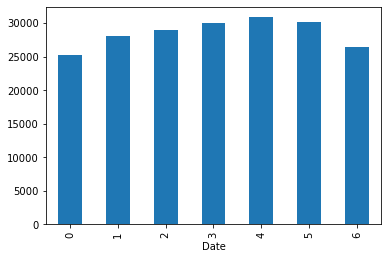

In [31]:
uberdf["Distance"].groupby(uberdf["Date"].dt.weekday).count().plot(kind="bar")

## Removing Rows with very high distance and 0 distance (outliers)

In [32]:
print(uberdf["Distance"].mean())
print(len(uberdf))

20.855349825361202
200000


In [33]:
uberdf = uberdf[uberdf['Distance'] <= 50]
uberdf = uberdf[uberdf['Distance'] != 0]

In [34]:
#removing trips with 0 longitude or 0 longitude

uberdf = uberdf[uberdf['Start_Lon'] != 0]
uberdf = uberdf[uberdf['Start_Lat'] != 0]
uberdf = uberdf[uberdf['End_Lon'] != 0]
uberdf = uberdf[uberdf['End_Lat'] != 0]

#removing trips with 0 total amount

uberdf = uberdf[uberdf['Total_Amt'] != 0]

* Removing trips outside latitude/longitude box

In [35]:
uberdf=outside(uberdf)

In [36]:
print(uberdf["Distance"].mean())
print(len(uberdf))

3.33772817297078
193512


In [37]:
uberdf=uberdf.assign(Date=uberdf.Date.dt.round('H'))

# Creating dataframe combining yellow taxi and uber data

In [38]:
#Adding a column 'Type' to identify whether Taxi was Uber or Yellow

uberdf_flag=uberdf
uberdf_flag["Type"]="Uber"

yellowdf_flag=yellowdf
yellowdf_flag["Type"]="Yellow"


df_list = [uberdf_flag[['Total_Amt', 'Trip_Pickup_DateTime', 'Start_Lon', 'Start_Lat',
       'End_Lon', 'End_Lat', 'Date', 'Distance','Type']],yellowdf_flag[['Total_Amt', 'Trip_Pickup_DateTime', 'Start_Lon', 'Start_Lat',
       'End_Lon', 'End_Lat', 'Date', 'Distance','Type']]]
tdf=pd.concat(df_list, ignore_index=True)

In [39]:
tdf=tdf.assign(Date=tdf.Date.dt.round('H'))

In [40]:
tdf.sample(n=10)

,Total_Amt,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Date,Distance,Type
142785,11.5,2012-11-07 12:12:00 UTC,-73.983520,40.760842,-73.999752,40.758937,2012-11-07 12:00:00,1.383451,Uber
342483,14.0,2013-04-01 09:27:14,-73.976474,40.751960,-73.962029,40.779607,2013-04-01 09:00:00,3.306156,Yellow
178433,7.5,2013-09-19 02:58:22 UTC,-73.947426,40.779402,-73.938502,40.796291,2013-09-19 03:00:00,2.022681,Uber
75598,8.5,2011-11-11 07:37:47 UTC,-73.967696,40.787710,-73.980113,40.758931,2011-11-11 08:00:00,3.366571,Uber
186596,18.5,2014-09-04 12:44:35 UTC,-73.978802,40.761870,-73.997412,40.724627,2014-09-04 13:00:00,4.428076,Uber
144760,8.5,2012-10-06 19:05:14 UTC,-73.947792,40.770908,-73.972025,40.765693,2012-10-06 19:00:00,2.121550,Uber
359579,11.9,2013-10-22 08:05:00,-73.992812,40.728247,-73.980285,40.751497,2013-10-22 08:00:00,2.792411,Yellow
358236,5.7,2013-09-17 08:07:00,-74.008130,40.714687,-74.009312,40.720012,2013-09-17 08:00:00,0.600434,Yellow
161020,8.9,2010-03-12 19:15:00 UTC,-73.981715,40.743160,-74.003230,40.731585,2010-03-12 19:00:00,2.223174,Uber
233535,7.9,2010-02-28 00:46:07,-73.986244,40.730536,-74.003444,40.738177,2010-02-28 01:00:00,1.679922,Yellow


# Weather Dataset

* Loading and processing weather dataset

In [41]:
#Load all weather csv into one dataframe
path = r'weather' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
    li.append(eachweatherdf)

weatherdf = pd.concat(li, axis=0, ignore_index=True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1334377732.py:8: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1334377732.py:8: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1334377732.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1334377732.py:8: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  eachweatherdf = pd.read_csv(filename, index_col=None, header=0)
C:\Users\Kunal\AppData\Local\Temp\ipy

In [42]:
weatherdf["DATE"]=weatherdf["DATE"].astype("datetime64")

* Removing Dates after 2015 June

In [43]:
weatherdf = weatherdf[ (weatherdf['DATE'].dt.year < 2015) | (weatherdf['DATE'].dt.month <= 6) ]

### Creating Dataframe with daily and hourly weather data

In [44]:
dayweather=pd.DataFrame()
dayweather=weatherdf[weatherdf['HourlyDryBulbTemperature'].notna() & weatherdf['HourlyWindSpeed'].notna()]
dayweather['day'] = dayweather.DATE.dt.date
# dayweather.set_index("DATE")

C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\3935078564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayweather['day'] = dayweather.DATE.dt.date


In [45]:
dayweather=dayweather[["DATE","HourlyDryBulbTemperature","HourlyWindSpeed"]]
dayweather['HourlyDryBulbTemperature']=pd.to_numeric(dayweather['HourlyDryBulbTemperature'], errors='coerce')
dayweather['HourlyWindSpeed']=pd.to_numeric(dayweather['HourlyWindSpeed'], errors='coerce')
dayweather.rename(columns={"HourlyWindSpeed":"DailyAvgWindSpeed","HourlyDryBulbTemperature":"DailyTemperature"},inplace=True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1676369403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayweather['HourlyDryBulbTemperature']=pd.to_numeric(dayweather['HourlyDryBulbTemperature'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1676369403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayweather['HourlyWindSpeed']=pd.to_numeric(dayweather['HourlyWindSpeed'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\1676369403.py:4: SettingWithCopyWa

In [46]:
dayweather.head()

,DATE,DailyTemperature,DailyAvgWindSpeed
0,2009-01-01 00:51:00,18.0,18.0
1,2009-01-01 01:51:00,18.0,18.0
2,2009-01-01 02:51:00,18.0,18.0
3,2009-01-01 03:51:00,18.0,8.0
4,2009-01-01 04:51:00,18.0,11.0


In [47]:
daydf = dayweather.groupby([dayweather['DATE'].dt.date]).mean()

In [48]:
daydf.sample(10)

,DailyTemperature,DailyAvgWindSpeed
DATE,,
2013-07-11,79.640000,3.840000
2012-04-28,48.954545,6.136364
2013-05-24,56.212766,4.936170
2011-03-19,46.000000,8.956522
2010-11-06,45.000000,5.291667
2010-01-02,25.269231,12.269231
2011-06-03,66.333333,6.750000
2011-11-12,48.250000,7.375000
2011-11-21,51.851852,4.666667


### Hourly data

In [49]:
hourweather=pd.DataFrame()
hourweather=weatherdf
hourweather['day'] = hourweather.DATE.dt.date
# dayweather.set_index("DATE")

In [50]:
hourweather=hourweather[["DATE","HourlyDryBulbTemperature","HourlyWindSpeed","HourlyPrecipitation"]]
hourweather['HourlyDryBulbTemperature']=pd.to_numeric(hourweather['HourlyDryBulbTemperature'], errors='coerce')
hourweather['HourlyWindSpeed']=pd.to_numeric(hourweather['HourlyWindSpeed'], errors='coerce')
hourweather['HourlyPrecipitation']=pd.to_numeric(hourweather['HourlyPrecipitation'], errors='coerce')
hourweather.rename(columns={"HourlyDryBulbTemperature":"HourlyTemperature"},inplace=True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\127846862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourweather['HourlyDryBulbTemperature']=pd.to_numeric(hourweather['HourlyDryBulbTemperature'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\127846862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourweather['HourlyWindSpeed']=pd.to_numeric(hourweather['HourlyWindSpeed'], errors='coerce')
C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\127846862.py:4: SettingWithCopyW

In [51]:
hourweather.head()

,DATE,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
0,2009-01-01 00:51:00,18.0,18.0,NaN
1,2009-01-01 01:51:00,18.0,18.0,NaN
2,2009-01-01 02:51:00,18.0,18.0,NaN
3,2009-01-01 03:51:00,18.0,8.0,NaN
4,2009-01-01 04:51:00,18.0,11.0,NaN


In [52]:
hourweather=hourweather.assign(DATE=hourweather.DATE.dt.round('H'))

In [53]:
hourdf = hourweather.groupby([hourweather['DATE']]).mean()

In [54]:
hourdf.head()

,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
DATE,,,
2009-01-01 01:00:00,18.0,18.0,NaN
2009-01-01 02:00:00,18.0,18.0,NaN
2009-01-01 03:00:00,18.0,18.0,NaN
2009-01-01 04:00:00,18.0,8.0,NaN
2009-01-01 05:00:00,18.0,11.0,NaN


In [55]:
hourdf.sample(10)

,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
DATE,,,
2013-04-29 05:00:00,54.0,0.0,NaN
2009-12-07 04:00:00,34.0,0.0,NaN
2014-12-20 07:00:00,31.0,6.0,0.0
2011-07-11 03:00:00,75.0,0.0,NaN
2011-07-09 15:00:00,86.0,6.0,NaN
2011-04-29 00:00:00,66.0,7.0,NaN
2009-03-16 18:00:00,45.0,5.0,NaN
2012-04-17 17:00:00,75.0,6.0,NaN
2014-06-30 14:00:00,83.0,NaN,0.0


# Part 2 - SQL - Storing Data

In [115]:
# first create a connection - we'll create a new database 
from sqlalchemy import create_engine

engine = create_engine(f"sqlite:///f4.db", echo=True)
dbname="f4.db"

In [116]:
# changing the format of the log messages that sqlalchemy will
# now print out, just for easier reading;
# we also do this after we create an engine since the 
# logger doesn't exist beforehand
import logging
sqllogger = logging.getLogger("sqlalchemy.engine.Engine")
formatter = logging.Formatter("[sqlalchemy] %(message)s")
sqllogger.handlers[0].setFormatter(formatter)

In [117]:
f=open("schema.sql","r")
query=f.read()
print(query)
f.close

-- creates tables

CREATE TABLE IF NOT EXISTS uber (
	"index" BIGINT, 
	"Total_Amt" FLOAT, 
	"Trip_Pickup_DateTime" TEXT, 
	"Start_Lon" FLOAT, 
	"Start_Lat" FLOAT, 
	"End_Lon" FLOAT, 
	"End_Lat" FLOAT, 
	"Date" DATETIME, 
	"Distance" FLOAT, 
	"Type" TEXT
);

CREATE TABLE IF NOT EXISTS yellow (
	"index" BIGINT, 
	"Trip_Pickup_DateTime" TEXT, 
	"Start_Lon" FLOAT, 
	"Start_Lat" FLOAT, 
	"End_Lon" FLOAT, 
	"End_Lat" FLOAT, 
	"Tip_Amt" FLOAT,
	"Total_Amt" FLOAT, 
	"Date" DATETIME, 
	"Distance" FLOAT, 
	"Type" TEXT
);

CREATE TABLE hourtable (
	"DATE" DATETIME, 
	"HourlyTemperature" FLOAT, 
	"HourlyWindSpeed" FLOAT, 
	"HourlyPrecipitation" FLOAT
);

CREATE TABLE daytable (
	"DATE" DATE, 
	"DailyTemperature" FLOAT, 
	"DailyAvgWindSpeed" FLOAT
);

CREATE VIEW IF NOT EXISTS HurricaneSandy3 AS
    SELECT Date,
           Count( * ) Number_of_Rides
      FROM (
               SELECT Date,
                      Distance
                 FROM (
                          SELECT Date,
               

<function TextIOWrapper.close()>

In [118]:
!sqlite3 $dbname < schema.sql

In [119]:
uberdf.to_sql("uber",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO uber ("index", "Total_Amt", "Trip_Pickup_DateTime", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "Date", "Distance", "Type") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
[sqlalchemy] [generated in 1.07599s] ((0, 7.5, '2015-05-07 19:52:06 UTC', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, '2015-05-07 20:00:00.000000', 1.6833227524029715, 'Uber'), (1, 7.7, '2009-07-17 20:04:56 UTC', -73.994355, 40.728225, -73.99471, 40.750325, '2009-07-17 20:00:00.000000', 2.4575898837790673, 'Uber'), (2, 12.9, '2009-08-24 21:45:00 UTC', -74.005043, 40.74077, -73.962565, 40.772647, '2009-08-24 22:00:00.000000', 5.036377190242826, 'Uber'), (3, 5.3, '2009-06-26 08:22:21 UTC', -73.976124, 40.790844, -73.965316, 40.803349, '2009-06-26 08:00:00.000000', 1.6616834584355225, 'Uber'), (4, 16.0, '2014-08-28 17:47:00 UTC', -73.925023, 40.744085, -73.97308199999999, 

193512

In [120]:
yellowdf.to_sql("yellow",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO yellow ("index", "Trip_Pickup_DateTime", "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "Tip_Amt", "Total_Amt", "Date", "Distance", "Type") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
[sqlalchemy] [generated in 1.59679s] ((0, '2009-01-13 07:54:28', -73.96156999999998, 40.768545, -73.96364199999998, 40.774218, 0.0, 4.9, '2009-01-13 08:00:00.000000', 0.654495481292893, 'Yellow'), (1, '2009-01-22 09:02:19', -73.914399, 40.746171, -73.816812, 40.703619, 0.0, 49.3, '2009-01-22 09:00:00.000000', 9.487618881241971, 'Yellow'), (2, '2009-01-23 23:52:45', -73.874395, 40.77401, -73.981739, 40.765671, 0.0, 29.95, '2009-01-24 00:00:00.000000', 9.087111076641122, 'Yellow'), (3, '2009-01-06 18:34:58', -73.957687, 40.765477, -73.977345, 40.729237, 1.0, 12.1, '2009-01-06 19:00:00.000000', 4.356703498069769, 'Yellow'), (4, '2009-01-02 09:52:00', -74.000105, 40.761962, -73.97110999

226373

In [121]:
hourdf.to_sql("hourweather",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] 
CREATE TABLE hourweather (
	"DATE" DATETIME, 
	"HourlyTemperature" FLOAT, 
	"HourlyWindSpeed" FLOAT, 
	"HourlyPrecipitation" FLOAT
)


[sqlalchemy] [no key 0.00026s] ()
[sqlalchemy] CREATE INDEX "ix_hourweather_DATE" ON hourweather ("DATE")
[sqlalchemy] [no key 0.00042s] ()
[sqlalchemy] COMMIT
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO hourweather ("DATE", "HourlyTemperature", "HourlyWindSpeed", "HourlyPrecipitation") VALUES (?, ?, ?, ?)
[sqlalchemy] [generated in 0.18440s] (('2009-01-01 01:00:00.000000', 18.0, 18.0, None), ('2009-01-01 02:00:00.000000', 18.0, 18.0, None), ('2009-01-01 03:00:00.000000', 18.0, 18.0, None), ('2009-01-01 04:00:00.000000', 18.0, 8.0, None), ('2009-01-01 05:00:00.000000', 18.0, 11.0, None), ('2009-01-01 06:00:00.000000', 16.0, 18.0, None), ('2009-01-0

56048

In [122]:
daydf.to_sql("dayweather",con=engine,if_exists='append')

[sqlalchemy] PRAGMA main.table_info("dayweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("dayweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] 
CREATE TABLE dayweather (
	"DATE" DATE, 
	"DailyTemperature" FLOAT, 
	"DailyAvgWindSpeed" FLOAT
)


[sqlalchemy] [no key 0.00025s] ()
[sqlalchemy] CREATE INDEX "ix_dayweather_DATE" ON dayweather ("DATE")
[sqlalchemy] [no key 0.00045s] ()
[sqlalchemy] COMMIT
[sqlalchemy] BEGIN (implicit)
[sqlalchemy] INSERT INTO dayweather ("DATE", "DailyTemperature", "DailyAvgWindSpeed") VALUES (?, ?, ?)
[sqlalchemy] [generated in 0.00599s] (('2009-01-01', 20.75, 11.041666666666666), ('2009-01-02', 31.322580645161292, 6.806451612903226), ('2009-01-03', 32.833333333333336, 9.875), ('2009-01-04', 33.888888888888886, 7.37037037037037), ('2009-01-05', 41.2962962962963, 6.925925925925926), ('2009-01-06', 32.62068965517241, 7.137931034482759), ('2009-01-07', 35.68421052631579, 9.842105263157896), ('2009-01-08', 34.8

2359

# Part 3 - SQL Queries - Understanding Data

### 1.   For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [123]:
query1='''
SELECT COUNT(*) total_yellow_rides, strftime('%H', Date) hour
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC'''

In [124]:
f = open("sql/query1.sql", "w")
f.write(query1)
f.close()

In [125]:
# !sqlite3 $dbname < sql/q1.sql

In [126]:
engine.execute(query1).fetchall()

[sqlalchemy] 
SELECT COUNT(*) total_yellow_rides, strftime('%H', Date) hour
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC
[sqlalchemy] [raw sql] ()


[(14285, '19'),
 (13934, '20'),
 (12984, '21'),
 (12745, '22'),
 (12679, '18'),
 (12059, '23'),
 (11342, '15'),
 (11223, '14'),
 (11167, '12'),
 (10823, '13'),
 (10530, '09'),
 (10363, '10'),
 (10193, '16'),
 (10186, '00'),
 (10117, '11'),
 (9793, '17'),
 (9477, '08'),
 (7745, '01'),
 (6542, '07'),
 (5765, '02'),
 (4191, '03'),
 (3321, '04'),
 (2947, '06'),
 (1962, '05')]

In [127]:
f = open("sql/query1.sql", "w")
f.write(query1)
f.close()

### 2. For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [128]:
query2='''
SELECT COUNT(*) Total_Uber_Rides, strftime('%w', Date) Day_of_Week
FROM uber
GROUP BY Day_of_Week
ORDER BY COUNT(*) DESC'''

In [129]:

# !sqlite3 $dbname < sql/q2.sql

In [130]:
#day of week 0-6 with Sunday==0
engine.execute(query2).fetchall()

[sqlalchemy] 
SELECT COUNT(*) Total_Uber_Rides, strftime('%w', Date) Day_of_Week
FROM uber
GROUP BY Day_of_Week
ORDER BY COUNT(*) DESC
[sqlalchemy] [raw sql] ()


[(29759, '5'),
 (29227, '6'),
 (28923, '4'),
 (28028, '3'),
 (27133, '2'),
 (26071, '0'),
 (24371, '1')]

In [131]:
f = open("sql/query2.sql", "w")
f.write(query2)
f.close()

### 3.What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [132]:
query3='''
WITH p AS (
    SELECT Distance,
           NTILE(100) OVER (ORDER BY Distance) AS percentile_bucket
      FROM (
               SELECT Distance
                 FROM uber
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
               UNION ALL
               SELECT Distance
                 FROM yellow
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
           )
)
SELECT MAX(Distance) AS Distance
  FROM p
 WHERE percentile_bucket = 95;'''

In [133]:
# !sqlite3 $dbname < sql/q3.sql

In [134]:
#Dividing the data in 20 buckets with each having 5 %ile 
#The 19th bucket will correspond to 95 %ile
engine.execute(query3).fetchall()

[sqlalchemy] 
WITH p AS (
    SELECT Distance,
           NTILE(100) OVER (ORDER BY Distance) AS percentile_bucket
      FROM (
               SELECT Distance
                 FROM uber
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
               UNION ALL
               SELECT Distance
                 FROM yellow
                WHERE Date >= '2013-07' AND 
                      Date <= '2013-08'
           )
)
SELECT MAX(Distance) AS Distance
  FROM p
 WHERE percentile_bucket = 95;
[sqlalchemy] [raw sql] ()


[(10.21608572432051,)]

In [135]:
f = open("sql/query3.sql", "w")
f.write(query3)
f.close()

### 4.What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [136]:
query4='''
Select COUNT(Distance) Rides,AVG(Distance) Average_Distance,strftime('%Y-%m-%d', Date) Date
from (SELECT Distance,Date FROM uber WHERE strftime('%Y', Date) IN('2009') UNION ALL 
SELECT Distance,Date FROM yellow WHERE strftime('%Y', Date) IN('2009')) 
GROUP BY strftime('%Y-%m-%d', Date) ORDER BY Rides DESC LIMIT 10
'''

In [137]:
# !sqlite3 $dbname < sql/q4.sql

In [138]:
engine.execute(query4).fetchall()

[sqlalchemy] 
Select COUNT(Distance) Rides,AVG(Distance) Average_Distance,strftime('%Y-%m-%d', Date) Date
from (SELECT Distance,Date FROM uber WHERE strftime('%Y', Date) IN('2009') UNION ALL 
SELECT Distance,Date FROM yellow WHERE strftime('%Y', Date) IN('2009')) 
GROUP BY strftime('%Y-%m-%d', Date) ORDER BY Rides DESC LIMIT 10

[sqlalchemy] [raw sql] ()


[(259, 3.3600973680036885, '2009-12-11'),
 (232, 2.792622867915958, '2009-01-24'),
 (229, 3.0433766790373444, '2009-11-07'),
 (228, 2.6602590094018863, '2009-02-20'),
 (226, 2.459683685993068, '2009-02-12'),
 (225, 3.4167465702804254, '2009-11-06'),
 (223, 3.3236647207557257, '2009-09-12'),
 (222, 3.507321072353886, '2009-04-18'),
 (222, 2.943716124851853, '2009-01-09'),
 (221, 3.4108612558827947, '2009-07-09')]

In [139]:
f = open("sql/query4.sql", "w")
f.write(query4)
f.close()

### 5. Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [140]:
query5='''
SELECT COUNT(*) Number_of_Rides,Date as Windiest_Dates from (SELECT Distance,strftime('%Y-%m-%d', Date) Date from uber UNION ALL Select Distance,strftime('%Y-%m-%d', Date) Date from yellow) WHERE Date
IN(SELECT strftime('%Y-%m-%d', Date) Day 
from dayweather ORDER BY DailyAvgWindSpeed DESC LIMIT 10) GROUP BY Date;
'''

In [141]:
# !sqlite3 $dbname < sql/q5.sql

In [142]:
engine.execute(query5).fetchall()

[sqlalchemy] 
SELECT COUNT(*) Number_of_Rides,Date as Windiest_Dates from (SELECT Distance,strftime('%Y-%m-%d', Date) Date from uber UNION ALL Select Distance,strftime('%Y-%m-%d', Date) Date from yellow) WHERE Date
IN(SELECT strftime('%Y-%m-%d', Date) Day 
from dayweather ORDER BY DailyAvgWindSpeed DESC LIMIT 10) GROUP BY Date;

[sqlalchemy] [raw sql] ()


[(220, '2009-04-04'),
 (198, '2009-11-13'),
 (106, '2010-02-06'),
 (254, '2010-03-13'),
 (24, '2010-12-27'),
 (237, '2011-02-19'),
 (181, '2012-02-25'),
 (44, '2012-10-29'),
 (158, '2012-12-26'),
 (195, '2013-03-06')]

In [143]:
f = open("sql/query5.sql", "w")
f.write(query5)
f.close()

### 6. During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

- We use the VIEW HurricaneSandy3 we created earlier in the schema.sql which was as below

``` mysql
CREATE VIEW IF NOT EXISTS HurricaneSandy3 AS
    SELECT Date,
           Count( * ) Number_of_Rides
      FROM (
               SELECT Date,
                      Distance
                 FROM (
                          SELECT Date,
                                 Distance
                            FROM uber
                          UNION ALL
                          SELECT Date,
                                 Distance
                            FROM yellow
                      )
                WHERE Date >= '2012-10-21' AND 
                      Date <= '2012-11-03'
           )
     GROUP BY Date;
```

In [144]:
query6='''
SELECT strftime('%Y-%m-%d Hour %H', HurricaneSandy3.Date) Date_Hour,
       Number_of_Rides,
       hourweather.HourlyWindSpeed AS Sustained_Wind_Speed,
       hourweather.HourlyPrecipitation AS Hourly_Precipitation
  FROM HurricaneSandy3
       LEFT JOIN
       hourweather ON hourweather.DATE = HurricaneSandy3.Date;
'''

In [145]:
engine.execute(query6).fetchall()

[sqlalchemy] 
SELECT strftime('%Y-%m-%d Hour %H', HurricaneSandy3.Date) Date_Hour,
       Number_of_Rides,
       hourweather.HourlyWindSpeed AS Sustained_Wind_Speed,
       hourweather.HourlyPrecipitation AS Hourly_Precipitation
  FROM HurricaneSandy3
       LEFT JOIN
       hourweather ON hourweather.DATE = HurricaneSandy3.Date;

[sqlalchemy] [raw sql] ()


[('2012-10-21 Hour 00', 13, None, 0.0),
 ('2012-10-21 Hour 01', 17, 5.0, 0.0),
 ('2012-10-21 Hour 02', 14, 6.0, 0.0),
 ('2012-10-21 Hour 03', 7, 6.0, 0.0),
 ('2012-10-21 Hour 04', 5, 6.0, 0.0),
 ('2012-10-21 Hour 05', 2, 6.0, 0.0),
 ('2012-10-21 Hour 06', 1, 6.0, 0.0),
 ('2012-10-21 Hour 07', 3, 0.0, 0.0),
 ('2012-10-21 Hour 08', 2, 5.0, 0.0),
 ('2012-10-21 Hour 09', 4, 8.0, 0.0),
 ('2012-10-21 Hour 10', 3, 8.0, 0.0),
 ('2012-10-21 Hour 11', 13, 8.0, 0.0),
 ('2012-10-21 Hour 12', 8, 9.0, 0.0),
 ('2012-10-21 Hour 13', 10, None, 0.0),
 ('2012-10-21 Hour 14', 11, 5.0, 0.0),
 ('2012-10-21 Hour 15', 10, 9.0, 0.0),
 ('2012-10-21 Hour 16', 11, 5.0, 0.0),
 ('2012-10-21 Hour 17', 7, None, 0.0),
 ('2012-10-21 Hour 18', 11, 3.0, 0.0),
 ('2012-10-21 Hour 19', 12, 7.0, 0.0),
 ('2012-10-21 Hour 20', 10, 5.0, 0.0),
 ('2012-10-21 Hour 21', 6, 7.0, 0.0),
 ('2012-10-21 Hour 22', 5, 9.0, 0.0),
 ('2012-10-21 Hour 23', 4, 5.0, 0.0),
 ('2012-10-22 Hour 00', 4, 5.0, 0.0),
 ('2012-10-22 Hour 01', 1, 7.0, 0.0)

In [146]:
f = open("sql/query6.sql", "w")
f.write(query5)
f.close()

# Part 4: Visualizing the Data

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1. Create an appropriate visualization for the first query/question in part 3

In [148]:
dfvis1=pd.read_sql(query1,con=engine)

[sqlalchemy] PRAGMA main.table_info("
SELECT COUNT(*) total_yellow_rides, strftime('%H', Date) hour
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("
SELECT COUNT(*) total_yellow_rides, strftime('%H', Date) hour
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC")
[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT COUNT(*) total_yellow_rides, strftime('%H', Date) hour
FROM yellow
GROUP BY hour
ORDER BY COUNT(*) DESC
[sqlalchemy] [raw sql] ()


In [149]:
dfvis1

,total_yellow_rides,hour
0,14285,19
1,13934,20
2,12984,21
3,12745,22
4,12679,18
5,12059,23
6,11342,15
7,11223,14
8,11167,12
9,10823,13


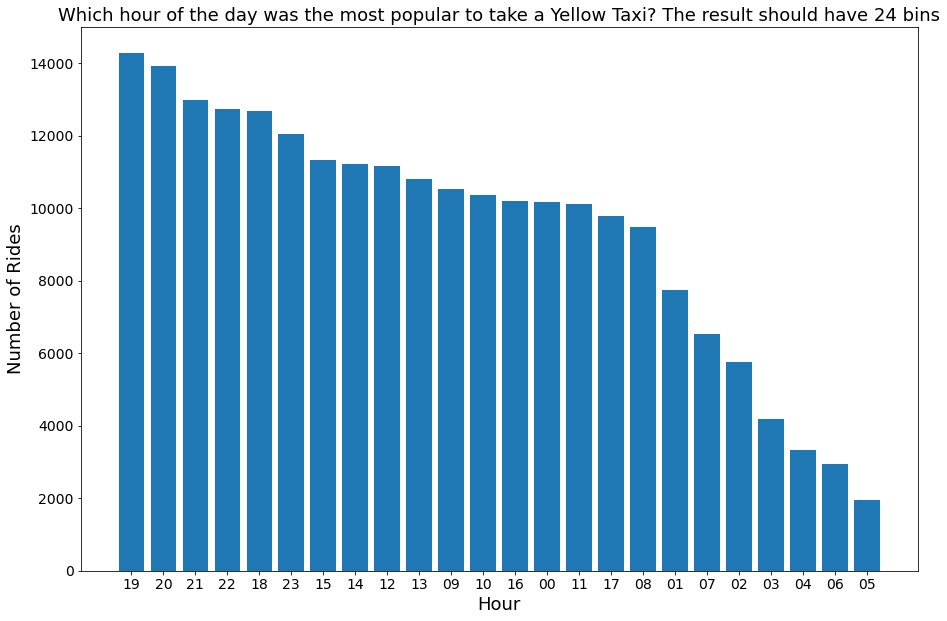

In [150]:
fig, ax = plt.subplots(figsize=(15, 10))
hours = dfvis1["hour"]
rides = dfvis1["total_yellow_rides"]
ax.bar(hours,rides)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel('Hour',fontsize=18)
ax.set_ylabel('Number of Rides',fontsize=18)
ax.set_title("Which hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins",fontsize=18)
plt.show()

### 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [151]:
df_uber=pd.read_sql("Select Distance,Date from uber",con=engine)
df_yellow=pd.read_sql("Select Distance,Date from yellow",con=engine)
df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Distance,Date from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Distance,Date from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Distance,Date from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Distance,Date from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Distance,Date from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Distance,Date from yellow
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\3810796568.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [152]:
len(df_combined)

419885

In [153]:
dfvis2=df_combined[["Distance","Date"]]

In [154]:
dfvis2.head()

,Distance,Date
0,1.683323,2015-05-07 20:00:00.000000
1,2.457590,2009-07-17 20:00:00.000000
2,5.036377,2009-08-24 22:00:00.000000
3,1.661683,2009-06-26 08:00:00.000000
4,4.475450,2014-08-28 18:00:00.000000


In [155]:
dfvis2=tdf[["Distance","Date"]].groupby(tdf.Date.dt.month)['Distance'].mean()

In [156]:
dfvis2

Date
1     3.177195
2     3.213851
3     3.310184
4     3.347576
5     3.438803
6     3.398810
7     3.382849
8     3.417610
9     3.367912
10    3.385765
11    3.373499
12    3.302147
Name: Distance, dtype: float64

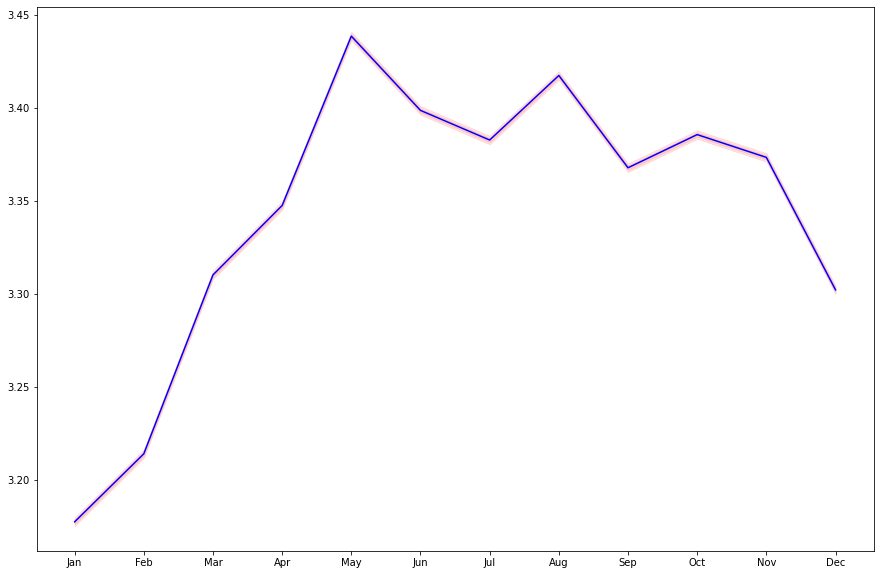

In [157]:
fig, ax = plt.subplots(figsize=(15, 10))
x = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
y = dfvis2
# Define the confidence interval
ci = 0.05 * np.std(y) / np.mean(y)
# Plot the sinus function
plt.plot(x, y,color='blue')
# Plot the confidence interval
plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.1)
plt.fill_between(x, (y-2*ci), (y+2*ci), color='red', alpha=0.1)
plt.show()

### 4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.


In [158]:
# !pip install keplergl

In [159]:
len(df_combined)

419885

In [160]:
df_uber=pd.read_sql("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber",con=engine)
df_yellow=pd.read_sql("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow",con=engine)
df_combined=df_uber.append(df_yellow)

[sqlalchemy] PRAGMA main.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from uber
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select Date,Start_Lon,Start_Lat,End_Lon,End_Lat  from yellow
[sqlalchemy] [raw sql] ()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_19816\2269989058.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_uber.append(df_yellow)


In [161]:
config1={'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '5ubthn',
     'type': 'heatmap',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start',
      'color': [18, 147, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Start_Lat', 'lng': 'Start_Lon'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '61sipgk',
     'type': 'point',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'end',
      'color': [221, 178, 124],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'End_Lat', 'lng': 'End_Lon', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '1qcteg',
     'type': 'arc',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start -> end arc',
      'color': [146, 38, 198],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'Start_Lat',
       'lng0': 'Start_Lon',
       'lat1': 'End_Lat',
       'lng1': 'End_Lon'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'e57dwbw',
     'type': 'line',
     'config': {'dataId': 'New York City Taxi Trips',
      'label': 'start -> end line',
      'color': [136, 87, 44],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'Start_Lat',
       'lng0': 'Start_Lon',
       'lat1': 'End_Lat',
       'lng1': 'End_Lon',
       'alt0': None,
       'alt1': None},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None,
       'elevationScale': 1},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'New York City Taxi Trips': [{'name': 'Date',
        'format': None},
       {'name': 'Start_Lon', 'format': None},
       {'name': 'Start_Lat', 'format': None},
       {'name': 'End_Lon', 'format': None},
       {'name': 'End_Lat', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.7535153683857,
   'longitude': -73.92178320729087,
   'pitch': 0,
   'zoom': 11.273086327374635,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [162]:
map_1 = KeplerGl(height=700,config=config1)
dfkepler=pd.read_csv("keplertestdata.csv")
df_combined_sub=df_combined.sample(10000)
map_1.add_data(data=df_combined_sub,name='New York City Taxi Trips')
map_1.save_to_html(file_name='mapadist.html',read_only=True)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to mapadist.html!


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5ubthn', 'type': '…

In [187]:
htmlfile=open("mapadist.html").read()
from IPython.display import display, HTML
display(HTML(htmlfile))




# orig_html = str("mapadist.html",'utf-8')

better_html = htmlfile
import base64
b64 = base64.b64encode(better_html.encode('utf-8'))
src = f"data:text/html;base64,{b64.decode('utf-8')}"
base64d_html = f'<iframe src="{src}" style="width:95%; height: 600px">'
import IPython
IPython.display.HTML(base64d_html)

### 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

In [163]:
dfvis5=pd.read_sql("Select * from yellow",con=engine)

[sqlalchemy] PRAGMA main.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from yellow
[sqlalchemy] [raw sql] ()


In [164]:
dfvis5=dfvis5[dfvis5["Tip_Amt"]!=0]
dfvis5=dfvis5[dfvis5["Tip_Amt"]<=15]
dfvis5=dfvis5[dfvis5["Distance"]!=0]
dfvis5=dfvis5[dfvis5["Distance"] <= 25]

In [165]:
dfvis5.head()

,index,Trip_Pickup_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,Tip_Amt,Total_Amt,Date,Distance,Type
3,3,2009-01-06 18:34:58,-73.957687,40.765477,-73.977345,40.729237,1.00,12.10,2009-01-06 19:00:00.000000,4.356703,Yellow
4,4,2009-01-02 09:52:00,-74.000105,40.761962,-73.971110,40.759072,2.00,9.70,2009-01-02 10:00:00.000000,2.463129,Yellow
5,5,2009-01-08 08:35:00,-73.923145,40.743860,-73.968245,40.751400,2.00,12.50,2009-01-08 09:00:00.000000,3.890651,Yellow
7,7,2009-01-21 10:06:26,-74.010729,40.714148,-74.010986,40.714739,4.87,37.37,2009-01-21 10:00:00.000000,0.069194,Yellow
23,23,2009-01-26 03:09:46,-73.985112,40.759521,-73.993492,40.758876,1.15,5.75,2009-01-26 03:00:00.000000,0.709446,Yellow


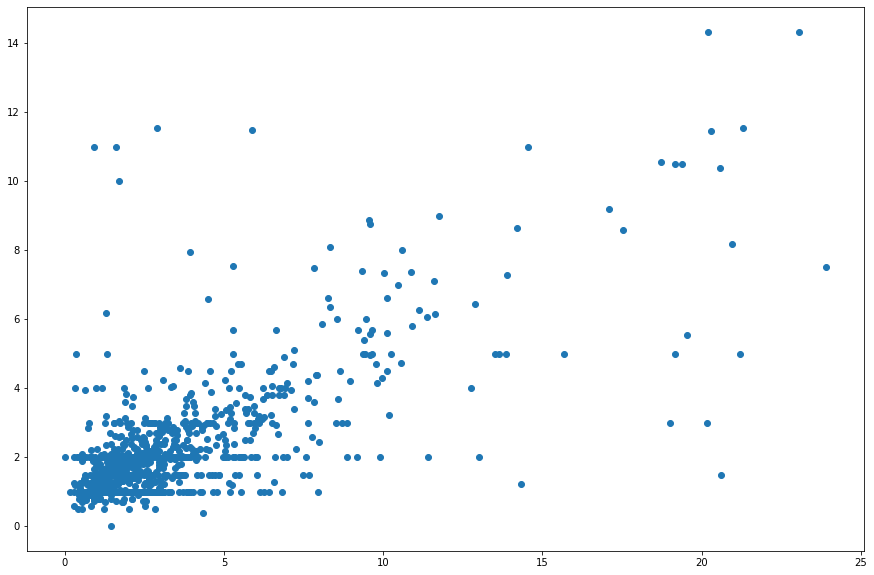

In [166]:
dfvis5sample=dfvis5.sample(1000)
fig, ax = plt.subplots(figsize=(15, 10))
x = dfvis5sample["Distance"]
y = dfvis5sample["Tip_Amt"]

plt.scatter(x, y)
plt.show()

### 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [167]:
df_yellow=pd.read_sql("Select * from yellow",con=engine)

[sqlalchemy] PRAGMA main.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from yellow")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from yellow
[sqlalchemy] [raw sql] ()


In [168]:
df_hourly=pd.read_sql("Select * from hourweather",con=engine)

[sqlalchemy] PRAGMA main.table_info("Select * from hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.table_info("Select * from hourweather")
[sqlalchemy] [raw sql] ()
[sqlalchemy] Select * from hourweather
[sqlalchemy] [raw sql] ()


In [169]:
df_hourly.head()

,DATE,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
0,2009-01-01 01:00:00.000000,18.0,18.0,NaN
1,2009-01-01 02:00:00.000000,18.0,18.0,NaN
2,2009-01-01 03:00:00.000000,18.0,18.0,NaN
3,2009-01-01 04:00:00.000000,18.0,8.0,NaN
4,2009-01-01 05:00:00.000000,18.0,11.0,NaN


In [170]:
df_yellow=df_yellow[["Date","Tip_Amt","Distance"]]

In [171]:
dfvis6 = pd.merge(df_yellow, df_hourly, how='inner', left_on = 'Date', right_on = 'DATE')
dfvis6=dfvis6[dfvis6["Tip_Amt"]!=0]
dfvis6=dfvis6[dfvis6["HourlyPrecipitation"]!=0]
dfvis6=dfvis6[dfvis6["HourlyPrecipitation"]<=0.5]
dfvis6=dfvis6[dfvis6["Tip_Amt"]<=15]
dfvis6=dfvis6[dfvis6["Distance"]!=0]
dfvis6=dfvis6[dfvis6["Distance"] <= 25]

In [172]:
dfvis6.tail()

,Date,Tip_Amt,Distance,DATE,HourlyTemperature,HourlyWindSpeed,HourlyPrecipitation
222766,2015-06-01 07:00:00.000000,4.16,7.781588,2015-06-01 07:00:00.000000,55.75,8.75,0.01
222767,2015-06-01 07:00:00.000000,0.96,0.607300,2015-06-01 07:00:00.000000,55.75,8.75,0.01
222786,2015-06-23 18:00:00.000000,1.35,1.490730,2015-06-23 18:00:00.000000,85.00,3.00,0.01
222977,2015-06-01 22:00:00.000000,4.00,9.013417,2015-06-01 22:00:00.000000,53.00,13.00,0.04
223004,2015-07-01 00:00:00.000000,1.50,5.976099,2015-07-01 00:00:00.000000,73.00,6.00,0.04


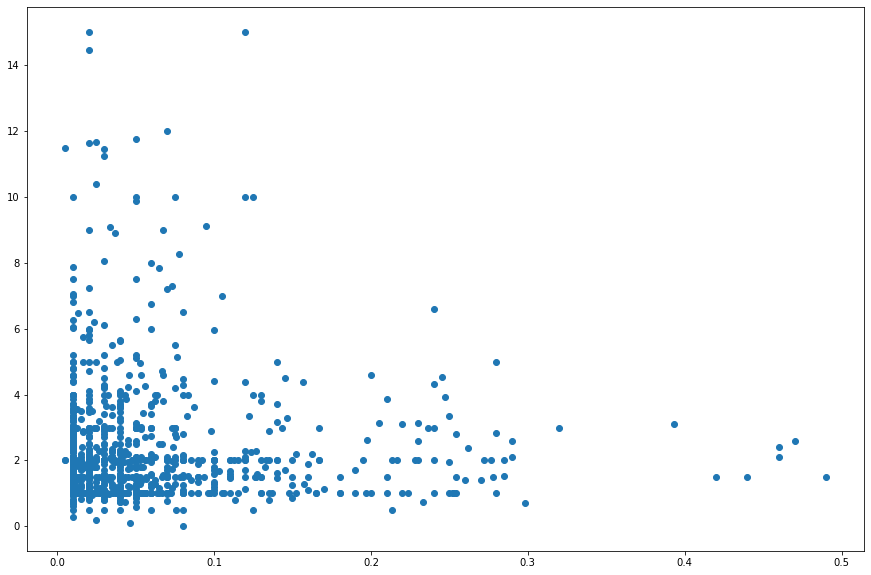

In [173]:
dfvis6sample=dfvis6.sample(1000)
fig, ax = plt.subplots(figsize=(15, 10))
x = dfvis6sample["HourlyPrecipitation"]
y = dfvis6sample["Tip_Amt"]

plt.scatter(x, y)
plt.show()